<a href="https://colab.research.google.com/github/Notenkraker02/INVICTI/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Optimization
### Instructions:
1. Run the sections "Functions" and "Final Model"
2. Proceed to the instructions for "Run Final Model"


## Functions

In [5]:
# Imports
import importlib.util

packages_to_install = ['numpy', 'pandas', 'datetime', 'yfinance', 'matplotlib', 'scipy', 'tabulate']

for package in packages_to_install:
    if importlib.util.find_spec(package) is None:
        print(f"Installing {package}...")
        %pip install {package}

import numpy as np
import pandas as pd
import datetime as dt
import yfinance
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tabulate import tabulate
from IPython.utils import io


#Standard Deviation
def st_dev(weights, cov_matrix):
    variance = np.dot(weights.transpose(), np.dot(cov_matrix, weights))
    return np.sqrt(variance)

#Expected Return given weights
def exp_return(weights, returns):
    return np.sum(returns.mean() * weights)

#Sharpe Ratio
def sharpe_ratio(weights, returns, cov_matrix, rf_rate):
    return (exp_return(weights, returns) - rf_rate)/st_dev(weights, cov_matrix)

def getPortfolio(weights, returns, cov_matrix, rf_rate):
    return weights, exp_return(weights, returns), st_dev(weights, cov_matrix), sharpe_ratio(weights, returns, cov_matrix, rf_rate)

# Generate portfolios with random weights
def generate_random_portfolios(returns, covariance, num_portfolios, risk_free_rate, min_allocations, max_allocations):
    num_assets = returns.shape[1]
    portfolios = []

    for _ in range(num_portfolios):
        weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]

        # Ensure that specified assets have weights greater than or equal to the specified minimum allocations
        # And have weights less than or equal to the specified maximum allocations
        iteration = 0
        while iteration < 100:
            updated = False
            sumFree = 0
            difference = 0
            temp_min_allocations = min_allocations.copy()
            temp_max_allocations = max_allocations.copy()
            for i in range(num_assets):
                initialWeight = weights[i]
                upper_bound = min(weights[i], max_allocations[i])
                weights[i] = max(min_allocations[i], upper_bound)
                difference += weights[i] - initialWeight
                if (min_allocations[i] == 0 and max_allocations[i] == 1) or weights[i] == initialWeight:
                    temp_min_allocations[i] = 0
                    temp_max_allocations[i] = 1
                    sumFree += weights[i]

            if difference != 0:
                updated = True
                iteration += 1

            if not updated:
                break

            for i in range(num_assets):
                if temp_min_allocations[i] == 0 and temp_max_allocations[i] == 1:
                    weights[i] *= (sumFree-difference)/sumFree

        returns_portfolio = exp_return(weights, returns)
        volatility_portfolio = st_dev(weights, covariance)
        sharpe_ratio_portfolio = sharpe_ratio(weights, returns, covariance, risk_free_rate)
        portfolios.append((weights, returns_portfolio, volatility_portfolio, sharpe_ratio_portfolio))

    return portfolios

# Plot the Efficient Frontier
def plot_efficient_frontier(portfolios, max_sharpe_portfolio):
    returns = [portfolio[1] for portfolio in portfolios]
    volatilities = [portfolio[2] for portfolio in portfolios]
    sharpe_ratios = [portfolio[3] for portfolio in portfolios]


    # Customizing color mapping to reflect full range of Sharpe ratios
    cmap = plt.get_cmap('viridis')
    colors = [cmap(sharpe_ratio) for sharpe_ratio in sharpe_ratios]

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(volatilities, returns, c=sharpe_ratios, cmap=cmap, marker='o')
    plt.scatter(max_sharpe_portfolio[2], max_sharpe_portfolio[1], color='red', marker='*', s=200, label='Max Sharpe Ratio Portfolio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.title('Efficient Frontier')

    # Create color bar
    cbar = plt.colorbar(scatter, label='Sharpe Ratio')
    cbar.set_label('Sharpe Ratio')

    plt.legend()
    plt.grid(True)
    plt.show()

def plot_portfolio(portfolio, tickers):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    weights, returns, volatility, sharpe_ratio = portfolio

    # Plot pie chart for asset allocation with customized style
    ax[0].pie(weights, labels=tickers, autopct='%1.2f%%', startangle=140)
    ax[0].set_title('Optimal Portfolio Weights')

    # Create a DataFrame for asset allocation
    portfolio_df = pd.DataFrame({'Asset': tickers, 'Weight': weights})
    portfolio_df['Weight'] = portfolio_df['Weight'].map('{:.2%}'.format)

    # Print portfolio statistics
    ax[1].text(0, 1, "Portfolio Overview:", fontsize=14, fontweight='bold', transform=ax[1].transAxes)
    ax[1].text(0, 0.9, f"Expected Annual Return: {returns:.2%}", fontsize=12, transform=ax[1].transAxes)
    ax[1].text(0, 0.8, f"Volatility: {volatility:.2%}", fontsize=12, transform=ax[1].transAxes)
    ax[1].text(0, 0.7, f"Sharpe Ratio: {sharpe_ratio:.2f}", fontsize=12, transform=ax[1].transAxes)
    ax[1].text(0, 0.6, "Asset Allocation:", fontsize=12, fontweight='bold', transform=ax[1].transAxes)
    for i, (asset, weight) in enumerate(zip(tickers, weights)):
        ax[1].text(0, 0.55 - 0.05 * i, f"{asset}: {weight:.2%}", fontsize=10, transform=ax[1].transAxes)
    ax[1].axis('off')

    plt.show()

## Final Model

In [6]:
def optimalPortfolio(tickers, num_portfolios, startTime, endTime, risk_free_rate, min_allocations, max_allocations):
   # Obtain Assets
   assets = []
   for ticker in tickers:
      data = yfinance.download(ticker, startTime, endTime)['Close']
      assets.append(data)
   assets = pd.concat(assets, axis = 1, keys = tickers)
   assets = assets.fillna(method='ffill').fillna(method='bfill')
   if "CASH" not in tickers:
      assets["CASH"] = 1
      tickers.append("CASH")

   #Obtain Returns
   returns = np.log(assets / assets.shift(1)) *252
   returns = returns.dropna()
   covariance = returns.cov()/252

   #Obtain portfolios
   portfolios = generate_random_portfolios(returns, covariance, num_portfolios, risk_free_rate, min_allocations, max_allocations)
   max_sharpe_portfolio = max(portfolios, key=lambda x: x[3])

   return portfolios, max_sharpe_portfolio

## Run Final Model
### Instructions:
0. Make sure the sections "Functions" and "Final Model" have been executed.
1. In "tickers" add the tickers of the assets you want to consider. In case you add/remove tickers, make sure to also look at point 5 of these instructions.
2. Adjust "time_horizon" to change how much data from the past the model considers. With INVICTI, we agree to all use a timeframe of ... days/months/years.
3. Adjust "num_portfolios" for the number of portfolios the model generates (how many points there are in the graph). More points mean a more accurately weighted portfolio, but takes longer to run. 10,000 points should be enough and runs in about 15-25 seconds. But you can always consider more points.
4. The risk-free rate is set as a default to 0.035 (3.5%) from the 9-Month German Bond Yield. If this changes over time, we can manually adjust it. (Also feel free to play around)
5. The "min_allocations" and "max_allocations" allow you to set a minimum or maximum to what weight we can give to each asset. When you add/remove tickers, you also have to add/remove constraints for these tickers. There is one more column than tickers, because the final column is for CASH (so keep that in mind when adding tickers). The default settings are 0 for minimum and 1 for maximum, which means that the weights are unconstrained.
5. Don't touch the rest of the code. 😀
6. Click the run button (▶) when you're ready.
7. Make some big bucks! 🤑

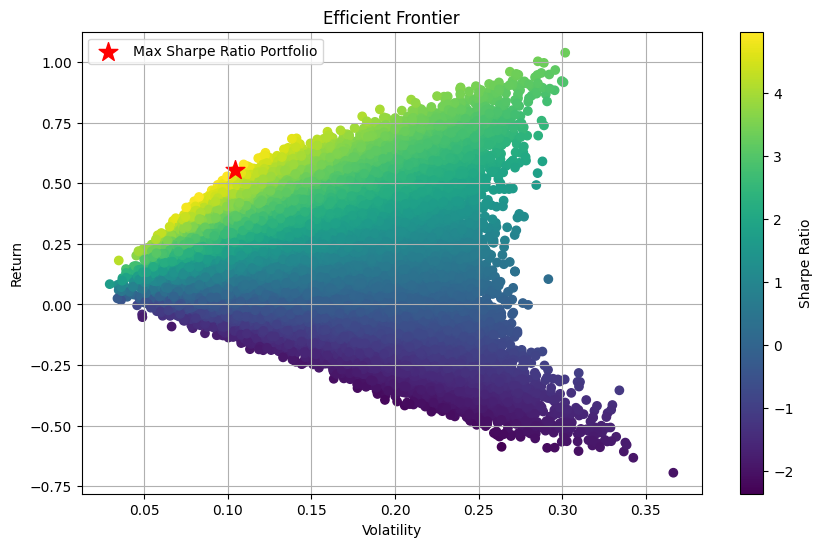

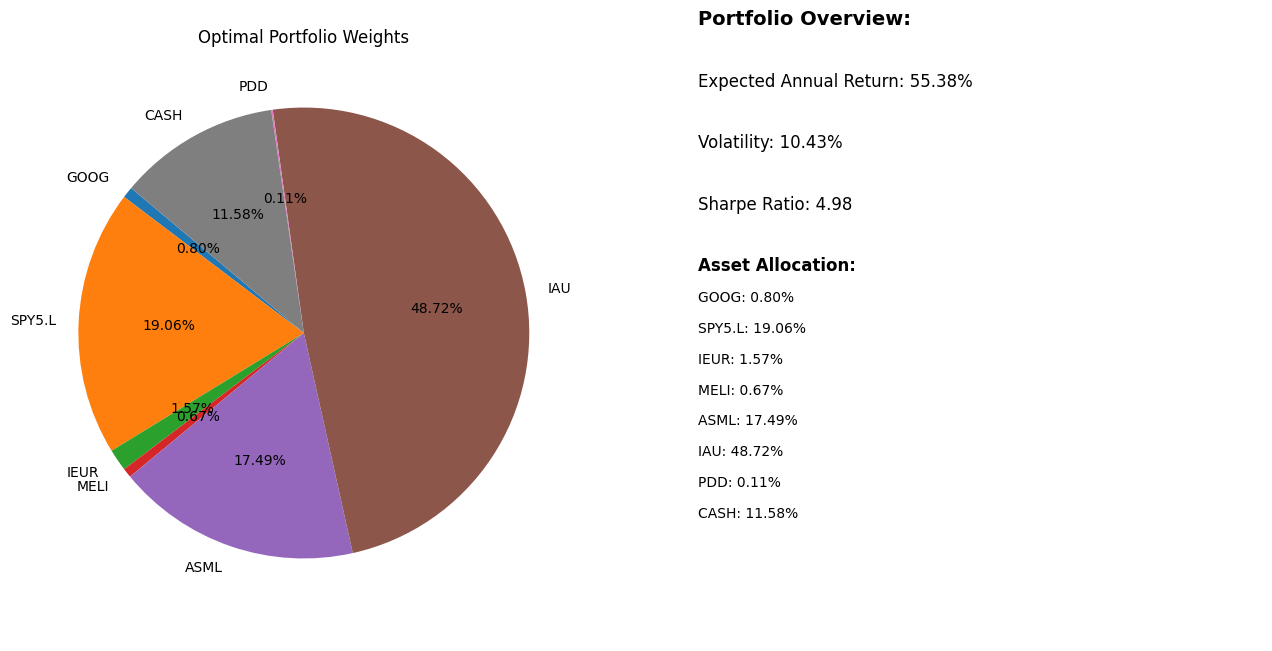

In [8]:
## Hyperparameters
tickers = ["GOOG", "SPY5.L", "IEUR", "MELI", "ASML", "IAU", "PDD"]
time_horizon = 90
num_portfolios = 100000
#Risk-free Rate
risk_free_rate = 0.035

#Minimum and Maximum Weight Allocations
min_allocations = [0,0,0,0,0,0,0,0]
max_allocations = [1,1,1,1,1,1,1,1]

# Interval Parameters
endTime = dt.datetime.now()
startTime = endTime - dt.timedelta(days = time_horizon)

#Perform model
with io.capture_output() as captured:
     portfolios, max_sharpe_portfolio = optimalPortfolio(tickers, num_portfolios, startTime, endTime, risk_free_rate, min_allocations, max_allocations)

# Plot efficient frontier
plot_efficient_frontier(portfolios, max_sharpe_portfolio)
plot_portfolio(max_sharpe_portfolio, tickers)